<h1>Содержание<span class="tocSkip"></span></h1><br>
<li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подключим необходимые библиотеки 

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

Загрузим данные

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)

Проверим данные на монотонность

In [4]:
df.index.is_monotonic

True

Ресемплируем данные по одному часу 

In [5]:
df = df.resample('1H').sum()

In [6]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Вывод

1) Загрузили данные;\
2) Проверели данные на монотонность;\
3) Ресемплировали данные по одному часу.


## Анализ

Посмотрим на график данных

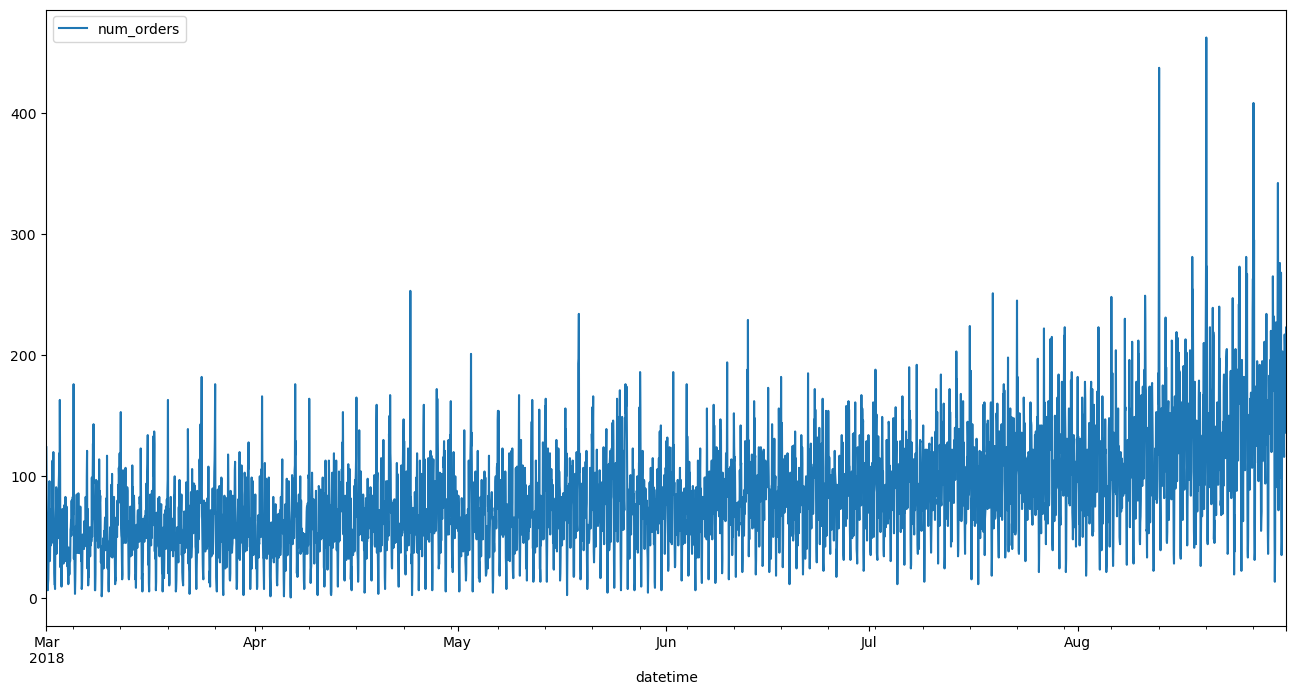

In [7]:
df.plot(figsize=(16,8));

Погмотри график 24 часовой скользящей средней

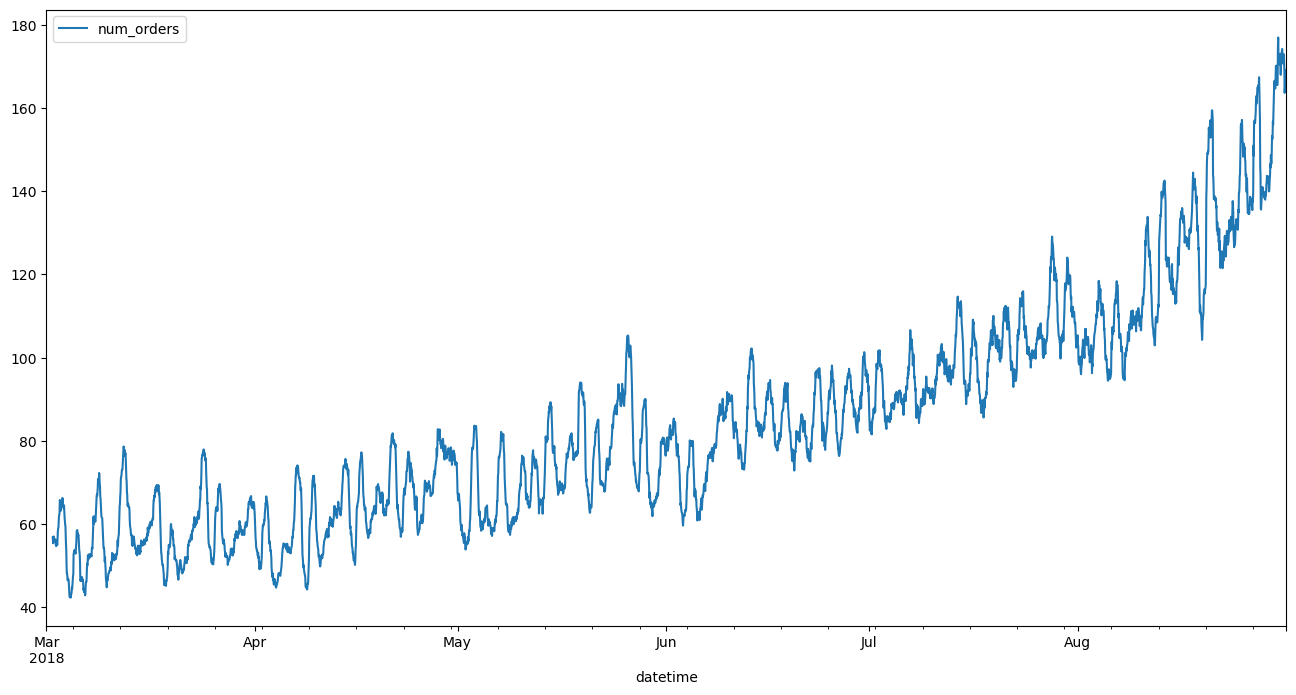

In [8]:
df.rolling(24).mean().plot(figsize=(16,8));

Разложим временной ряд на три составляющие: тренд, сезонность и остаток

In [9]:
decomposed = seasonal_decompose(df.rolling(24*14).mean().dropna())

Построим график тренда

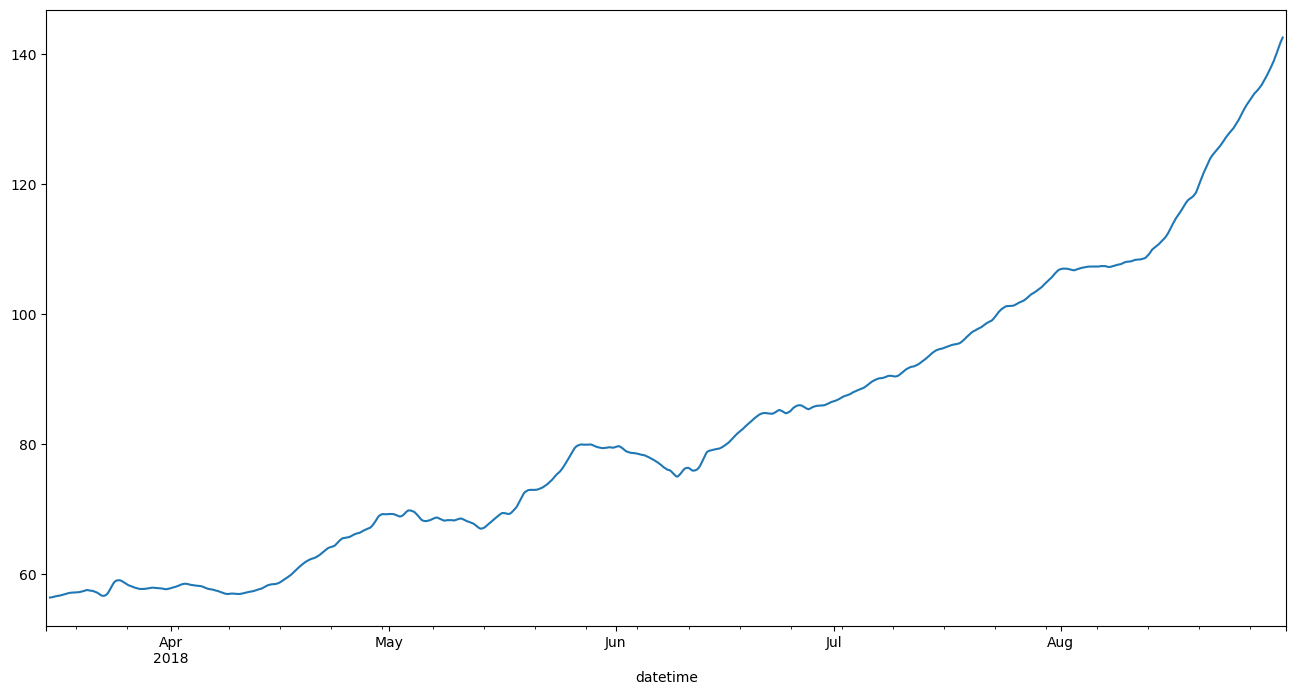

In [10]:
decomposed.trend.plot(figsize=(16,8));

Посмотрим график сезонности за 3 дня с 29 по 31 августва 2018 года

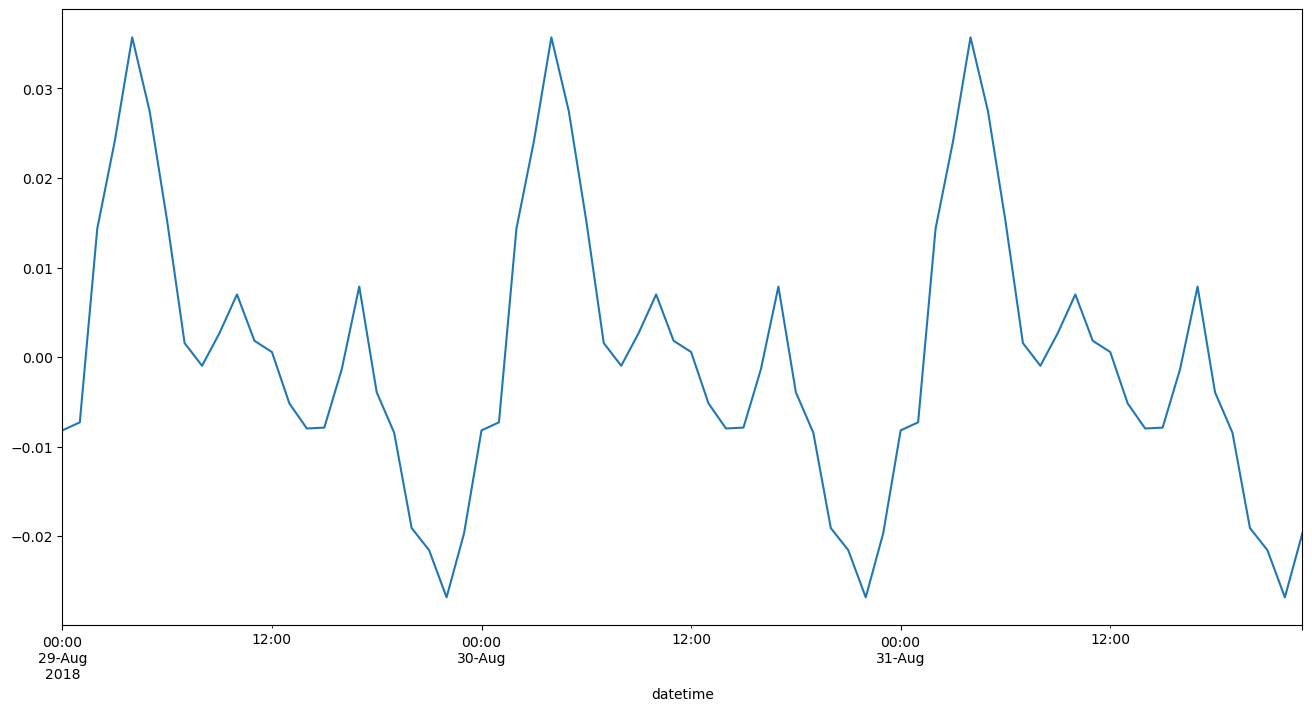

In [11]:
decomposed.seasonal['2018-08-29':'2018-08-31'].plot(figsize=(16,8));

Построим график остатка декомпозиции 

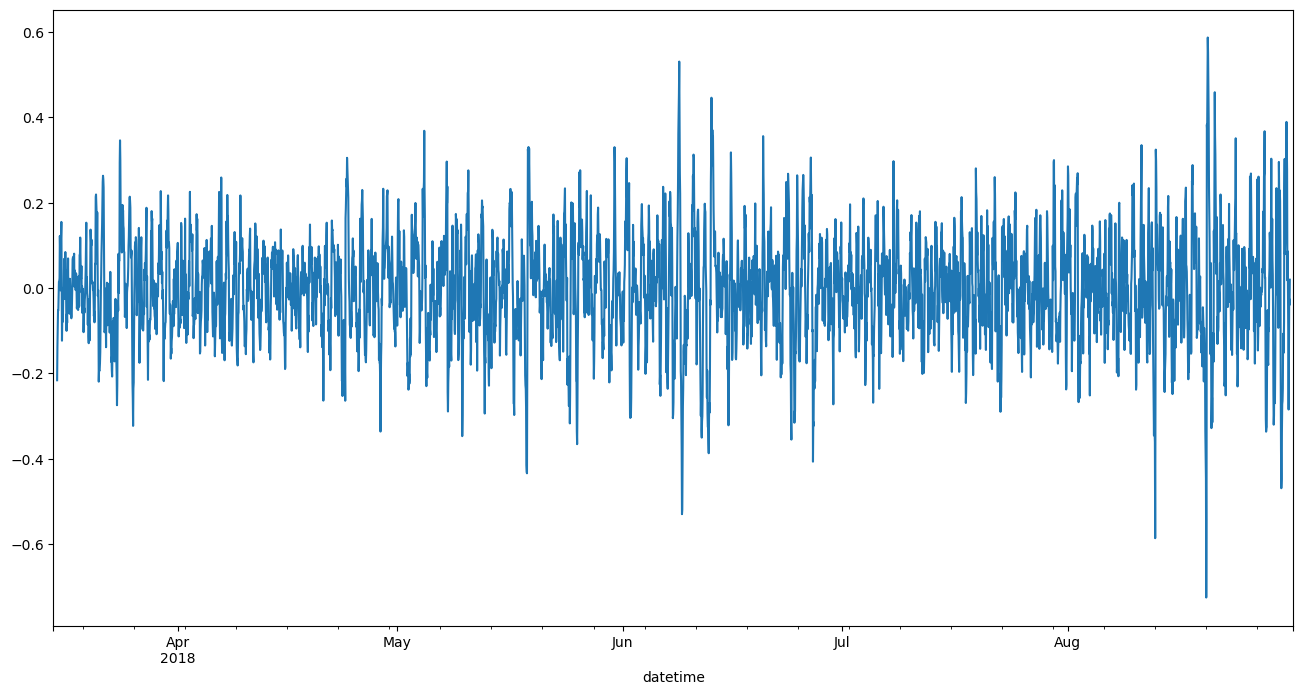

In [12]:
decomposed.resid.plot(figsize=(16,8));

Проведем тест Квятковского - Филлипса - Шмидта - Шина (KPSS)

In [13]:
test_0 = sm.tsa.stattools.kpss(df, regression='ct')
print('KPSS:', test_0[0])
print('p-value:', test_0[1])
print('Critical values:', test_0[3])
if test_0[0] > test_0[3]['1%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

KPSS: 1.5541377850842588
p-value: 0.01
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Есть единичные корни, ряд не стационарен


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


H 0 : Временной ряд имеет стационарный тренд\
H A : временной ряд не имеет стационарного тренда\
т.к. p-value = 0.01 < α = 0,05, то нулевая гипотеза, о стационарности ряда - отвергается

Проведем тест Дики - Фуллера

In [14]:
test_1 = adfuller(df)
print('adf:', test_1[0])
print('p-value:', test_1[1])
print('Critical values:', test_1[4])
if test_1[0] > test_1[4]['1%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf: -3.068924289027932
p-value: 0.02894005140261486
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Есть единичные корни, ряд не стационарен


H 0 : Временной ряд имеет стационарный тренд\
H A : временной ряд не имеет стационарного тренда\
т.к. p-value = 0.03 < α = 0,05, то нулевая гипотеза, о стационарности ряда - отвергается

### Вывод

1) Разложили временной ряд на тренд, сезонность и остаток;\
2) Тренд временного ряда имеет тенденцию к росу со временем;\
3) По сезонности временного ряда заметно, что наибольшый спрос на такси рано утром, так же есть 2 пика в обед и вечером после работы;\
4) Наименьший спрос, ожидаемо, ночью после 22 часов;\
5) Провели тестирование Квятковского - Филлипса - Шмидта - Шина (KPSS) - т.к. p-value = 0.01 < α = 0,05, то нулевая гипотеза, о стационарности ряда - отвергается\
6) Провели тестирование Дики - Фуллера - т.к. p-value = 0.03 < α = 0,05, то нулевая гипотеза, о стационарности ряда - отвергается


## Обучение

Создадим признаки для горизонта прогнозирования в один шаг

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [16]:
df_new = make_features(df, 200, 10)

/var/folders/s9/lqy1t4g94d5cw77z95378z7m0000gn/T/ipykernel_31548/2984940338.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
/var/folders/s9/lqy1t4g94d5cw77z95378z7m0000gn/T/ipykernel_31548/2984940338.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
/var/folders/s9/lqy1t4g94d5cw77z95378z7m0000gn/T/ipykernel_31548/2984940338.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is u

Разделим выборку на трейн и тест с учетом в пропорции 90/10, с сохранением порядка

In [17]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
train = train.dropna()

Выделим признаки и целевой признак в выборках 

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Создадим функцию для обучения и расчета RMSE модели

In [19]:
def rmse(model):
    
    model.fit(features_train, target_train)   
    y_pred = model.predict(features_test)
    rmse = np.sqrt(mean_squared_error(target_test, y_pred))

    return rmse, y_pred

Разделим выборку на 5 частей для кроссвалидации специальным методом для кросс-валидации

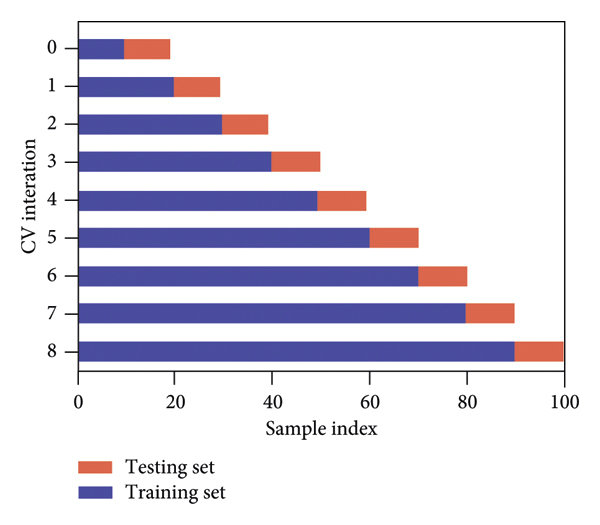

In [20]:
ts_cv = TimeSeriesSplit(n_splits=5)

Обучим модель линейной регрессии

In [21]:
model = LinearRegression()

search_space_linear = [{'fit_intercept': [True, False],
                        'normalize': [True, False]}]


gs_linear = GridSearchCV(model, 
                        search_space_linear, 
                        cv=ts_cv, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

rmse_linear, y_lr = rmse(gs_linear)

print('RMSE LinearRegression: ', round(rmse_linear, 0))

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make

RMSE LinearRegression:  34.0


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 an

Обучим модель CatBoost

In [22]:
model = CatBoostRegressor(loss_function='RMSE', silent=True)

search_space_catboost = [{'learning_rate': [0.03, 0.1],
                          'iterations': [40, 60, 80],
                          'depth': [3, 5]}]


gs_catboost = GridSearchCV(model, 
                        search_space_catboost, 
                        cv = ts_cv, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

rmse_catboost, y_cb = rmse(gs_catboost)

print('RMSE CatBoostRegressor: ', round(rmse_catboost, 0))

RMSE CatBoostRegressor:  37.0


### Вывод

1) Создали признаки для обучения моделей;\
2) Разделили выборки на с помощью TimeSeriesSplit для кросс-валидации временных рядов;\
3) Обучили модели линейной регрессии и CatBoost;\
4) RMSE линейной регрессии на кросс-валидации - 34.0;\
5) RMSE CatBoost на кросс-валидации - 37.0

## Тестирование

Для получения "бейзлайна" обучим модель Dummy

In [23]:
dummy = DummyRegressor(strategy='mean')

rmse_dummy, y_dummy = rmse(dummy)

print('RMSE Dummy: ', round(rmse_dummy, 0))

RMSE Dummy:  84.0


Сделаем прогнозирование по предыдущему значению

In [24]:
previous = test.shift(fill_value=train.iloc[-1]['num_orders'])

rmse_pred = np.sqrt(mean_squared_error(target_test, previous['num_orders']))
print('RMSE по предыдущему значению: ', round(rmse_pred, 0), 'заказов')

RMSE по предыдущему значению:  59.0 заказов


Посмотрим на результаты обученных моделей

In [25]:
data = {'RMSE':[rmse_linear, rmse_catboost, rmse_dummy, rmse_pred]}

t = pd.DataFrame(data)
t.index = ['LinearRegression', 'CatBoostRegressor', 'DummyRegressor', 'По предыдущему значению']
pd.set_option('display.float_format', '{:.0f}'.format)
display(t)

,RMSE
LinearRegression,34
CatBoostRegressor,37
DummyRegressor,84
По предыдущему значению,59


In [26]:
test['y_lr'] = y_lr
test['y_cb'] = y_cb
test['y_dummy'] = y_dummy

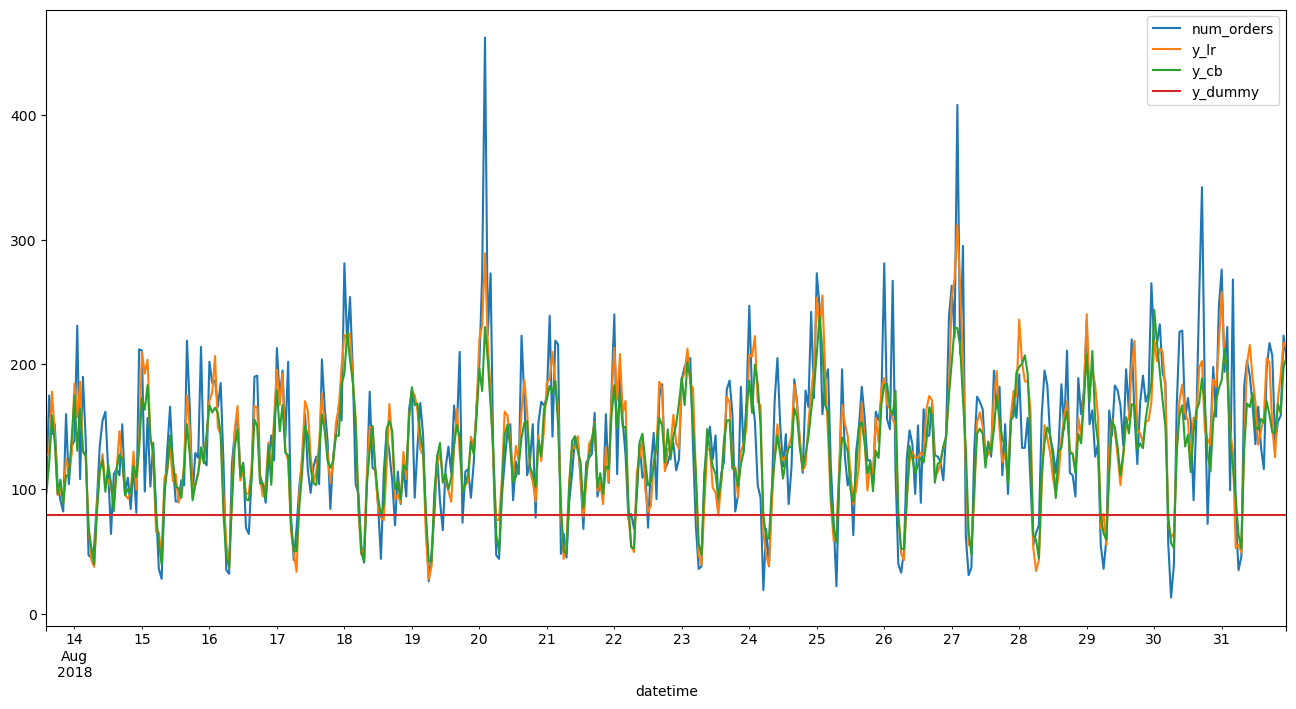

In [27]:
test[['num_orders', 'y_lr', 'y_cb', 'y_dummy']].plot(figsize=(16,8));

### Вывод

1) Для проверки модели на адекватность обучили Dummy модель;\
2) Сделали прогнозированние по предыдущему значению временного ряда;\
3) RMSE линейной регрессии на тестовой выборке - 34;\
4) RMSE CatBoost на тестовой выборке - 37.0;\
5) RMSE Dummy на тестовой выборке - 84.0;\
6) RMSE по предыдущему значению - 59